# PYCE Loans Insurance Model

### Machine Learning Model for calculating the probability of loan default and estimating interest rates to maximize profits

### Methods used and compared: Linear Regression, Logistic Regression, Random Forest

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
results = pd.read_csv('Result_Stage1_25.csv').drop('id', axis = 1)
results

,own,competing1,competing3,borrowertype,accepted,default,profit
0,NaN,0.405000,0.236840,0,0,0,NaN
1,NaN,0.092714,0.152445,2,0,1,NaN
2,NaN,0.060536,NaN,0,0,0,NaN
3,0.040365,0.159082,0.004469,0,0,0,NaN
4,NaN,0.944560,0.297304,3,0,0,NaN
...,...,...,...,...,...,...,...
99995,0.060634,0.088147,0.165407,0,1,0,606.34381
99996,NaN,0.234034,NaN,0,0,0,NaN
99997,NaN,0.193021,0.178011,0,0,0,NaN
99998,NaN,0.300000,0.125500,0,0,0,NaN


In [4]:
results.describe().round(3)

,own,competing1,competing3,borrowertype,accepted,default,profit
count,20908.000,93772.000,73433.000,100000.00,100000.000,100000.000,12005.000
mean,0.059,0.262,0.253,0.60,0.120,0.198,-101.403
std,0.017,0.211,0.167,1.02,0.325,0.398,2658.640
min,0.040,0.000,0.000,0.00,0.000,0.000,-10000.000
25%,0.043,0.103,0.142,0.00,0.000,0.000,433.464
50%,0.055,0.224,0.214,0.00,0.000,0.000,562.741
75%,0.073,0.383,0.316,1.00,0.000,0.000,738.773
max,0.093,1.000,1.000,3.00,1.000,1.000,926.195


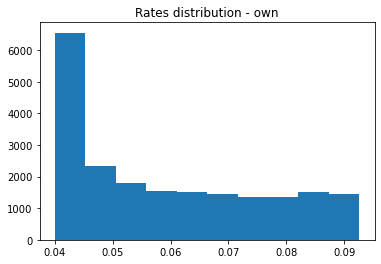

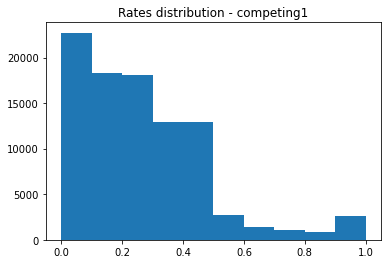

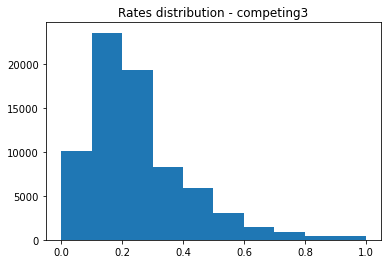

In [5]:
plt.hist(results.own)
plt.title('Rates distribution - own')
plt.show()

plt.hist(results.competing1)
plt.title('Rates distribution - competing1')
plt.show()

plt.hist(results.competing3)
plt.title('Rates distribution - competing3')
plt.show()


## Functions

- Calculate our profit based on the competitors' interest rate and on the borrower preferences. We can use it to simulate different strategies
- Calculate competing1 and competing3 performance

In [6]:
def calculate_profit(row):
    if np.isnan(row.rate):
        return np.nan
    elif np.isnan(row.competing1) and np.isnan(row.competing3):
        return np.nan
    elif np.isnan(row.competing1):
        if row.borrowertype != 3 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        else:
            return np.nan
    elif np.isnan(row.competing3):
        if row.borrowertype != 1 and row.rate < row.competing1:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.01999999:
            return aux(row.default, row.rate)
        else:
            return np.nan
    else: #all bid
        if row.borrowertype == 0 and row.rate < row.competing1 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.rate < row.competing3 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.0199999 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.rate < row.competing1 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        else:
            return np.nan

In [7]:
def aux(default, competing1):
    if default:
        return -10000
    return 10000*competing1

def profit1(row):
    
    # No bid
    if np.isnan(row.competing1):
        return np.nan
    
    #Only bid
    elif np.isnan(row.own) and np.isnan(row.competing3):
        return aux(row.default, row.competing1)
    
    #Competes only with competing3
    elif np.isnan(row.own):
        if row.borrowertype != 3 and row.competing1 < row.competing3:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 3 and row.competing3 - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.competing3 < 0.01999999:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
    #Competes only with own    
    elif np.isnan(row.competing3):
        if row.borrowertype != 2 and row.competing1 < row.own:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 2 and row.own - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.own < 0.01999999:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
    #All companies bid
    else: 
        if row.borrowertype == 0 and row.competing1 < row.own and row.competing1 < row.competing3:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.own < 0.0199999 and row.competing1 - row.competing3 < 0.01999999:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 2 and row.competing1 < row.competing3 and row.own - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 3 and row.competing1 < row.own and row.competing3 - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
        
        
def profit3(row):
    if np.isnan(row.profit) and np.isnan(row.profit1) and not np.isnan(row.competing3):
        return aux(row.default, row.competing3)
    return np.nan

In [8]:
start_time = time.time()

results['profit1'] = results.apply(profit1, axis = 1)
results['profit3'] = results.apply(profit3, axis = 1)

print("--- {:.2f} seconds ---".format(time.time() - start_time))
results

--- 14.65 seconds ---


,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3
0,NaN,0.405000,0.236840,0,0,0,NaN,NaN,2368.398900
1,NaN,0.092714,0.152445,2,0,1,NaN,-10000.00000,NaN
2,NaN,0.060536,NaN,0,0,0,NaN,605.36075,NaN
3,0.040365,0.159082,0.004469,0,0,0,NaN,NaN,44.694184
4,NaN,0.944560,0.297304,3,0,0,NaN,NaN,2973.042700
...,...,...,...,...,...,...,...,...,...
99995,0.060634,0.088147,0.165407,0,1,0,606.34381,NaN,NaN
99996,NaN,0.234034,NaN,0,0,0,NaN,2340.34240,NaN
99997,NaN,0.193021,0.178011,0,0,0,NaN,NaN,1780.105100
99998,NaN,0.300000,0.125500,0,0,0,NaN,NaN,1254.999900


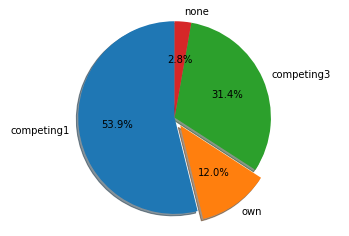

In [9]:
labels = 'competing1','own', 'competing3', 'none'
a = results[results.profit.notnull()].shape[0]
b = results[results.profit1.notnull()].shape[0]
c = results[results.profit3.notnull()].shape[0]
d = results.shape[0] - (a+b+c)
sizes = [b, a, c, d]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
print('We won {:.1f}% of our bids'.format(a/results[results.own.notnull()].shape[0]*100))
print('Competing1 won {:.1f}% of their bids'.format(b/results[results.competing1.notnull()].shape[0]*100))
print('Competing3 won {:.1f}% of their bids'.format(c/results[results.competing3.notnull()].shape[0]*100))

We won 57.4% of our bids
Competing1 won 57.4% of their bids
Competing3 won 42.7% of their bids


In [11]:
#Join probabilities
sr_prob = pd.read_csv('updated_probs_stage1.csv', index_col = 0)
final = pd.concat([sr_prob, results], axis = 1)
final

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3
0,0.291848,NaN,0.405000,0.236840,0,0,0,NaN,NaN,2368.398900
1,0.175391,NaN,0.092714,0.152445,2,0,1,NaN,-10000.00000,NaN
2,0.079274,NaN,0.060536,NaN,0,0,0,NaN,605.36075,NaN
3,0.014177,0.040365,0.159082,0.004469,0,0,0,NaN,NaN,44.694184
4,0.239929,NaN,0.944560,0.297304,3,0,0,NaN,NaN,2973.042700
...,...,...,...,...,...,...,...,...,...,...
99995,0.059121,0.060634,0.088147,0.165407,0,1,0,606.34381,NaN,NaN
99996,0.400499,NaN,0.234034,NaN,0,0,0,NaN,2340.34240,NaN
99997,0.238915,NaN,0.193021,0.178011,0,0,0,NaN,NaN,1780.105100
99998,0.173570,NaN,0.300000,0.125500,0,0,0,NaN,NaN,1254.999900


In [14]:
def total_profit(cut, floor):
    x = final.copy()
    x['rate'] = np.where(x['probability'] < cut, x['probability']/(1-x['probability']) + floor, np.nan)
    x.loc[x["rate"] > 1, "rate"] = 1
    x['profit'] = x.apply(calculate_profit, axis=1)
    profit = x.profit.sum()
    loans = x[x['rate'].notnull()].shape[0]
    wins = x[x['profit'].notnull()].shape[0]
    defaults = x[x['profit'].notnull()][x['default'] == 1].shape[0]
    return profit, loans, wins, defaults

In [15]:
print(total_profit(0.05, 0.04))

(1465415.2445373558, 13702, 4376, 156)


In [ ]:
%%time
#df_profit = pd.DataFrame(columns = ['cut', 'floor', 'profit', 'loans', 'wins'])
d = []
for i in range(1, 51):
    #print(i)
    for j in range(0, 101):
        print(i, j)
        cut = i*0.01
        floor = j*0.005
        profit, loans, wins, defaults = total_profit(cut, floor)
        d_aux = {}
        d_aux['cut'] = cut
        d_aux['floor'] = floor
        d_aux['profit'] = profit
        d_aux['loans'] = loans
        d_aux['wins'] = wins
        d_aux['defaults'] = defaults
        d.append(d_aux)
        #df_profit.loc[-1] = [cut, floor, profit, loans, wins]
        #df_profit.index = df_profit.index + 1  # shifting index
        #df_profit = df_profit.sort_index()

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 88
2 89
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
2 100
3 0
3 1


16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
16 100
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 21
17 22
17 23
17 24
17 25
17 26
17 27
17 28
17 29
17 30
17 31
17 32
17 33
17 34
17 35
17 36
17 37
17 38
17 39
17 40
17 41
17 42
17 43
17 44
17 45
17 46
17 47
17 48
17 49
17 50
17 51
17 52
17 53
17 54
17 55
17 56
17 57
17 58
17 59
17 60
17 61
17 62
17 63
17 64
17 65
17 66
17 67
17 68
17 69
17 70
17 71
17 72
17 73
17 74
17 75
17 76
17 77
17 78
17 79
17 80
17 81
17 82
17 83
17 84
17 85
17 86
17 87
17 88
17 89
17 90
17 91
17 92
17 93
1

29 99
29 100
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 96
30 97
30 98
30 99
30 100
31 0
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17
31 18
31 19
31 20
31 21
31 22
31 23
31 24
31 25
31 26
31 27
31 28
31 29
31 30
31 31
31 32
31 33
31 34
31 35
31 36
31 37
31 38
31 39
31 40
31 41
31 42
31 43
31 44
31 45
31 46
31 47
31 48
31 49
31 50
31 51
31 52
31 53
31 54
31 55
31 56
31 57
31 58
31 59
31 60
31 61
31 62
31 63
31 64
31 65
31 6

In [ ]:
%%time
df_profit = pd.DataFrame.from_dict(dictionary_list)
df_profit.sort_values('profit', ascending = False)

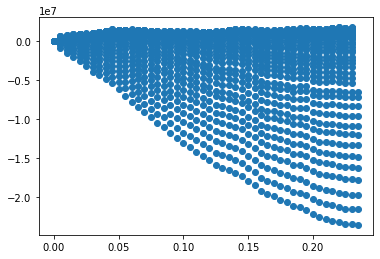

In [29]:
plt.scatter(df_profit['cut'], df_profit['profit'])

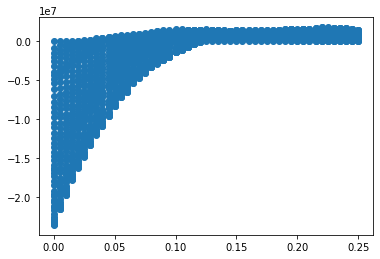

In [30]:
plt.scatter(df_profit['floor'], df_profit['profit'])

In [16]:
print(cut, floor)

1.0 0.245


In [29]:
final['winner'] = final.apply(winner, axis = 1)

In [1]:
d_aux

NameError: name 'd_aux' is not defined

In [19]:
final.to_csv('data.csv')

## Winning bids comparison

- Competitors 1: won 54% of bids
- Our company: won 57% of bids
- Competitors 3: won 46% of bids

At the same time, our overall performance was significantly better than the competition, although it was still a loss

In [49]:
print(a, b, c)

12005 53850 31366


In [67]:
wins = final.winner.value_counts().sort_index().astype(float)
wins

0     2779.0
1    51211.0
2    12005.0
3    34005.0
Name: winner, dtype: float64

In [68]:
wins[1] /= final[final.competing1.notnull()].shape[0]
wins[2] /= final[final.own.notnull()].shape[0]
wins[3] /= final[final.competing3.notnull()].shape[0]
wins.drop(0)

1    0.546123
2    0.574182
3    0.463075
Name: winner, dtype: float64

In [64]:
final[['profit', 'profit1', 'profit3']].sum()

profit    -1.217340e+06
profit1   -2.226795e+07
profit3   -8.482774e+06
dtype: float64

In [65]:

labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<AxesSubplot:ylabel='winner'>

Error in callback <function flush_figures at 0x0000022EFCC72790> (for post_execute):


KeyboardInterrupt: 

In [75]:
def whatif(row):
    if np.isnan(row.own):
        return 0
    elif row.default == 1:
        return -10000
    else:
        return 10000*row.own

final['whatif'] = final.apply(whatif, axis=1)
final

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3,winner,whatif
0,0.273533,NaN,0.405000,0.236840,0.0,0.0,0.0,NaN,NaN,2368.398900,3,0.00000
1,0.033768,NaN,0.092714,0.152445,2.0,0.0,1.0,NaN,-10000.00000,NaN,1,0.00000
2,0.100804,NaN,0.060536,NaN,0.0,0.0,0.0,NaN,605.36075,NaN,1,0.00000
3,0.339204,0.040365,0.159082,0.004469,0.0,0.0,0.0,NaN,NaN,44.694184,3,403.65480
4,0.308897,NaN,0.944560,0.297304,3.0,0.0,0.0,NaN,NaN,2973.042700,3,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.358134,0.060634,0.088147,0.165407,0.0,1.0,0.0,606.34381,NaN,NaN,2,606.34382
99996,0.005387,NaN,0.234034,NaN,0.0,0.0,0.0,NaN,2340.34240,NaN,1,0.00000
99997,0.003103,NaN,0.193021,0.178011,0.0,0.0,0.0,NaN,NaN,1780.105100,3,0.00000
99998,0.000000,NaN,0.300000,0.125500,0.0,0.0,0.0,NaN,NaN,1254.999900,3,0.00000


In [76]:
final.whatif.sum()

1553109.5905700002

In [77]:
final.own -= 0.01

In [153]:
def aux(default, rate):
    if default:
        return -10000
    return 10000*rate

def winner(row):
    if np.isnan(row.rate):
        return 0
    elif np.isnan(row.competing1) and np.isnan(row.competing3):
        return 
    elif np.isnan(row.competing1):
        if row.borrowertype != 3 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        else:
            return 0
    elif np.isnan(row.competing3):
        if row.borrowertype != 1 and row.rate < row.competing1:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        else:
            return 0
    else: #all bid
        if row.borrowertype == 0 and row.rate < row.competing1 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.rate < row.competing3 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.0199999 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.rate < row.competing1 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        else:
            return 0

In [154]:
final['rate'] = final.own
final['winner'] = final.apply(winner, axis = 1)

In [156]:
final['dif'] = final.profit - final.winner
#l = list(final[final.profit > 0][final.winner == 0].index)
final[abs(final.dif) > 1]

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3,rate,winner,dif
730,0.001397,0.041399,0.040166,NaN,2.0,1.0,0.0,413.99072,NaN,NaN,0.041399,0.0,413.99072
10560,0.034104,0.075309,0.059000,NaN,2.0,1.0,0.0,753.08508,NaN,NaN,0.075309,0.0,753.08508
17501,0.013001,0.053173,0.037000,NaN,2.0,1.0,0.0,531.72632,NaN,NaN,0.053173,0.0,531.72632
23186,0.028922,0.069783,0.054683,NaN,2.0,1.0,1.0,-10000.00000,NaN,NaN,0.069783,0.0,-10000.00000
25979,0.005335,0.045364,0.039741,NaN,2.0,1.0,0.0,453.63919,NaN,NaN,0.045364,0.0,453.63919
25987,0.034435,0.075663,0.061356,NaN,2.0,1.0,0.0,756.62744,NaN,NaN,0.075663,0.0,756.62744
30054,0.001439,0.041442,0.040000,NaN,2.0,1.0,1.0,-10000.00000,NaN,NaN,0.041442,0.0,-10000.00000
38414,0.018722,0.059080,0.044883,NaN,2.0,1.0,0.0,590.79578,NaN,NaN,0.059080,0.0,590.79578
39338,0.022761,0.063291,0.045685,NaN,2.0,1.0,0.0,632.91089,NaN,NaN,0.063291,0.0,632.91089
43081,0.000000,0.040000,0.083307,0.04,0.0,1.0,0.0,400.00000,NaN,NaN,0.040000,0.0,400.00000


In [79]:
final['whatif'] = final.apply(whatif, axis=1)
final

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3,winner,whatif
0,0.273533,NaN,0.405000,0.236840,0.0,0.0,0.0,NaN,NaN,2368.398900,3,0.00000
1,0.033768,NaN,0.092714,0.152445,2.0,0.0,1.0,NaN,-10000.00000,NaN,1,0.00000
2,0.100804,NaN,0.060536,NaN,0.0,0.0,0.0,NaN,605.36075,NaN,1,0.00000
3,0.339204,0.030365,0.159082,0.004469,0.0,0.0,0.0,NaN,NaN,44.694184,3,303.65480
4,0.308897,NaN,0.944560,0.297304,3.0,0.0,0.0,NaN,NaN,2973.042700,3,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.358134,0.050634,0.088147,0.165407,0.0,1.0,0.0,606.34381,NaN,NaN,2,506.34382
99996,0.005387,NaN,0.234034,NaN,0.0,0.0,0.0,NaN,2340.34240,NaN,1,0.00000
99997,0.003103,NaN,0.193021,0.178011,0.0,0.0,0.0,NaN,NaN,1780.105100,3,0.00000
99998,0.000000,NaN,0.300000,0.125500,0.0,0.0,0.0,NaN,NaN,1254.999900,3,0.00000


In [80]:
final.whatif.sum()

-436590.40943

In [ ]:

    
def print_profit(cut, floor):
    x = final[final['probability'] <= cut]
    x['rate'] = x['probability']/(1-x['probability']) + floor
    x['profit'] = np.where(x['default'] == 0, 10000*x['rate'], -10000)
    #print('Cut: {:.2f}\tFloor: {:.2f}\tProfit: {:.2f}'.format(cut, floor, x.profit.sum()))
    return x.profit.sum()

In [ ]:
df_profit = pd.DataFrame(columns = ['cut', 'floor', 'profit'])
for i in range(0, 201):
    for j in range(0, 15):
        cut = + i*0.005
        floor = j*0.005
        profit = print_profit(cut, floor)
        df_profit.loc[-1] = [cut, floor, profit]
        df_profit.index = df_profit.index + 1  # shifting index
        df_profit = df_profit.sort_index()

In [5]:
# Prepare dataframe and identify model features relevant to loan defaults
def profits1(own, c1, c3, customer, default):
    #No loan given
    if np.isnan(c1):
        profit = np.nan
    else:
        
        #Only c1 gave loans
        if np.isnan(own) and np.isnan(c3):
            profit = -10000 if default == 1 else 10000*c1
        
        #We didn't give loans
        elif np.isnan(own) and c1 <= c3:
            if customer == 3 and c1 - c3 < 0.02:
                profit = np.nan
            else:
                profit = -10000 if default == 1 else 10000*c1
        
        #c3 didn't give loans
        #Since we already discarded the cases where own wins, c1 wins
        elif np.isnan(c3) and c1 <= own:
            profit = -10000 if default == 1 else 10000*c1
             
        #Everyone gives loans
        #Since we already discarded the cases where own wins, c1 can only lose to c3 now
        else:
            if (c3 < c1 and customer != 1) or (c3 - c1 <= 0.02 and customer == 1):
                profit = np.nan
            else:
                profit = -10000 if default == 1 else 10000*c1
    
    return profit
    

In [6]:
def profit(sr):
    # We won
    if not np.isnan(sr['profit']):
        p1 = np.nan
        p3 = np.nan
    else:
        p1 = profits1(sr['own'], sr['competing1'], sr['competing3'], sr['borrowertype'], sr['default'])
        if np.isnan(p1) and not np.isnan(sr['competing3']):
            p3 = -10000 if sr['default'] == 1 else 10000*sr['competing3']
        else:
            p3 = np.nan
    
    sr['profit1'] = p1
    sr['profit3'] = p3
    return sr

In [98]:
x = final.copy()

In [99]:
x['rate'] = np.where(x['probability'] < 0.05, x['probability']/(1-x['probability']) + 0.04, np.nan)

In [93]:
x['xxx'] = x.apply(winner, axis = 1)

In [101]:
x

,probability,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3,winner,whatif,rate
0,0.273533,NaN,0.405000,0.236840,0.0,0.0,0.0,NaN,NaN,2368.398900,3,0.00000,NaN
1,0.033768,NaN,0.092714,0.152445,2.0,0.0,1.0,NaN,-10000.00000,NaN,1,0.00000,0.074948
2,0.100804,NaN,0.060536,NaN,0.0,0.0,0.0,NaN,605.36075,NaN,1,0.00000,NaN
3,0.339204,0.030365,0.159082,0.004469,0.0,0.0,0.0,NaN,NaN,44.694184,3,303.65480,NaN
4,0.308897,NaN,0.944560,0.297304,3.0,0.0,0.0,NaN,NaN,2973.042700,3,0.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.358134,0.050634,0.088147,0.165407,0.0,1.0,0.0,606.34381,NaN,NaN,2,506.34382,NaN
99996,0.005387,NaN,0.234034,NaN,0.0,0.0,0.0,NaN,2340.34240,NaN,1,0.00000,0.045416
99997,0.003103,NaN,0.193021,0.178011,0.0,0.0,0.0,NaN,NaN,1780.105100,3,0.00000,0.043113
99998,0.000000,NaN,0.300000,0.125500,0.0,0.0,0.0,NaN,NaN,1254.999900,3,0.00000,0.040000


# Interest Rate Calculation

### The function is based on 3 main variables:

- Default risk: the probability above which we don't give loans
- Breakeven interest rate calculation: function of the probability of default
- Floot: minimal rate (for applicants with 0% probability of default according to the model

Our initial strategy was to minimize the number of loans and thus the default rate, allowing us to give lower interest rates than our competitors

In [44]:
x = rf_model[rf_model['probability'] <= 0.05]
x['rate'] = x['probability']/(1-x['probability']) + 0.04
x['profit'] = np.where(x['default'] == 0, 10000*x['rate'], -10000)
x

,sex,marital,income,social2,employed,retired,student,unemployed,default,probability,rate,profit
1,1,1,26108,0.592502,1.0,0.0,0.0,0.0,0,0.033768,0.074948,749.478389
12,1,1,15397,0.862322,1.0,0.0,0.0,0.0,0,0.031020,0.072013,720.133422
30,1,1,27316,0.692050,1.0,0.0,0.0,0.0,0,0.033053,0.074183,741.833086
50,0,1,25250,0.856491,1.0,0.0,0.0,0.0,0,0.026714,0.067447,674.469926
53,1,1,74023,0.536551,1.0,0.0,0.0,0.0,0,0.000108,0.040108,401.076374
...,...,...,...,...,...,...,...,...,...,...,...,...
99880,1,0,29429,0.486538,1.0,0.0,0.0,0.0,0,0.018747,0.059105,591.052348
99940,1,1,12923,0.879925,1.0,0.0,0.0,0.0,0,0.029655,0.070561,705.613647
99955,0,0,0,0.995915,0.0,0.0,1.0,0.0,0,0.038084,0.079592,795.919672
99992,1,1,10165,0.000000,0.0,1.0,0.0,0.0,0,0.021855,0.062343,623.430656


In [46]:
x.profit.sum()

316196.32420589996

## Run the model for new applicants

#### pyce_loans.csv: interest rates for new applicants (null if loan is denied)

In [47]:
def preprocess2(df):
    tot = df.copy()
    
    enc = OneHotEncoder(categories='auto') # Create dummy variables
    features = enc.fit_transform(tot[['employment']]).toarray() # Transform categorical into numerical
    names = np.concatenate(enc.categories_) # Transform above variables into column names
    
    l_drop = ['employment'] # Focus on social2 profiles
    X = pd.DataFrame(features, columns=names) # Create dataframe with dummy variables
    
    # Substitute categorical variable in original dataframe
    X = pd.concat([tot, X],axis=1) 
    X = X.drop(l_drop,axis=1)
    return X

In [49]:
start_time = time.time()


regr = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=10,
                      n_estimators=500, random_state=1)
df = pd.read_csv('LoanApplications_Stage1_Lender2.csv').drop('id', axis = 1)

X, y = preprocess(df_total)
regr.fit(X, y)
df['probability'] = regr.predict(preprocess2(df))

print("--- {:.2f} seconds ---".format(time.time() - start_time))
df

--- 75.32 seconds ---


,sex,employment,marital,income,social2,probability
0,1,employed,1,7787,0.521474,0.230177
1,1,retired,1,9286,0.072545,0.148238
2,1,employed,1,25586,0.193502,0.076151
3,1,employed,1,57661,0.904576,0.000365
4,1,retired,0,3943,0.325358,0.317087
...,...,...,...,...,...,...
99995,1,retired,0,22188,0.000000,0.020217
99996,1,student,0,0,0.391565,0.496161
99997,1,employed,1,5615,0.834428,0.177374
99998,1,unemployed,1,16573,0.318897,0.250118


In [50]:
df['rate'] = np.where(df['probability'] < 0.05, df['probability']/(1-df['probability']) + 0.04, None)
df.rate.value_counts(dropna = False)

NaN         79092
0.040000     1107
0.040030       97
0.040141       91
0.042004       73
            ...  
0.078637        1
0.079113        1
0.057483        1
0.085944        1
0.087566        1
Name: rate, Length: 15559, dtype: int64

In [51]:
df.drop('probability', axis = 1).to_csv('pyce_loans.csv')